# Conway's Game of Life

The goal of this post is to train a neural network to properly play [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) without explicitly teaching it the rules of the game:

    The universe of the Game of Life is an infinite, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, alive or dead, (or populated and unpopulated, respectively). Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

    - Any live cell with fewer than two live neighbors dies, as if by underpopulation.
    - Any live cell with two or three live neighbors lives on to the next generation.
    - Any live cell with more than three live neighbors dies, as if by overpopulation.
    - Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.

    The initial pattern constitutes the seed of the system. The first generation is created by applying the above rules simultaneously to every cell in the seed; births and deaths occur simultaneously, and the discrete moment at which this happens is sometimes called a tick. Each generation is a pure function of the preceding one. The rules continue to be applied repeatedly to create further generations.
    
- [Wikipedia, Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life#Rules)

## Game Logic

The first thing to do is define a function that takes a game board as input and returns the next state. Luckily there are plenty of implementations available online, such as the following from [ttps://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/](https://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/):

In [1]:
import numpy as np

def life_step(X):
    """
    'Game of Life' logic, from: 
    https://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/
    """
    live_neighbors = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (live_neighbors == 3) | (X & (live_neighbors == 2)).astype(int)

## Generate Game Boads

With the game logic in place, the next thing we'll want is some way to randomly generate game boards (frames) and a way to visualize them:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def generate_frames(num_frames, board_shape=(100,100), prob_alive=0.15):
    """
    Generates `num_frames` random game boards with a particular shape and a predefined 
    probability of each cell being 'alive'.
    """
    
    return np.array([
        np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])
        for _ in range(num_frames)
    ]).astype(int)

def render_frames(frame1, frame2):
    plt.subplot(1, 2, 1)
    plt.imshow(frame1.flatten().reshape(board_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(frame2.flatten().reshape(board_shape), cmap='gray')

Let's see what these frames look like:

In [3]:
board_shape = (20, 20)
board_size = board_shape[0] * board_shape[1]
probability_alive = 0.15

frames = generate_frames(10, board_shape=board_shape, prob_alive=probability_alive)
frames.shape # (num_frames, board_w, board_h)

(10, 20, 20)

In [4]:
frames[0]

array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0,

The following takes the integer representation of a game board from above, and renders it as an image. To the right it also renders the next state of the game board:

Sample frame vs. next step:


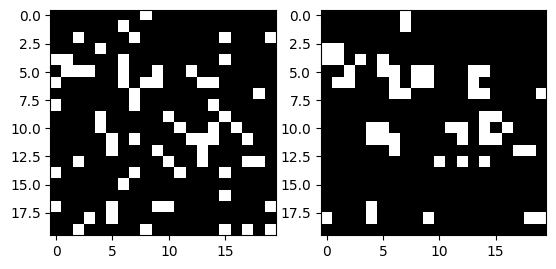

In [5]:
print("Sample frame vs. next step:")
render_frames(frames[1], life_step(frames[1]))

## Construct a Training and Validation Set

Now that we can generate data, we'll generate training, validation and test sets.

Each element in the `y_train`/`y_val`/`y_test` arrays will represent the **next** *Game of Life* board for each board frame in `X_train`/`X_val`/`X_test`.

In [6]:
def reshape_input(X):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

def generate_dataset(num_frames, board_shape, prob_alive):
    X = generate_frames(num_frames, board_shape=board_shape, prob_alive=prob_alive)
    X = reshape_input(X)
    y = np.array([
        life_step(frame) 
        for frame in X
    ])
    return X, y

train_size = 70000
val_size   = 10000
test_size  = 20000

In [7]:
print("Training Set:")
X_train, y_train = generate_dataset(train_size, board_shape, probability_alive)
print(X_train.shape)
print(y_train.shape)

Training Set:
(70000, 20, 20, 1)
(70000, 20, 20, 1)


In [8]:
print("Validation Set:")
X_val, y_val = generate_dataset(val_size, board_shape, probability_alive)
print(X_val.shape)
print(y_val.shape)

Validation Set:
(10000, 20, 20, 1)
(10000, 20, 20, 1)


In [9]:
print("Test Set:")
X_test, y_test = generate_dataset(test_size, board_shape, probability_alive)
print(X_test.shape)
print(y_test.shape)

Test Set:
(20000, 20, 20, 1)
(20000, 20, 20, 1)


## Build a Convolutional Neural Network

Now we can take a first crack at building a *Convolutional Neural Network* using [Keras](https://keras.io/layers/convolutional/). The key here is the `kernel_size` of `(3, 3)` and `strides` of `1`. This instructs the CNN to look at a `3x3` matrix of surrounding cells for each `1` cell of the board it looks at, including the current cell itself.

For example, if the following were a game board and we were at the middle cell `x`, it would look at all the cells marked with an exclamation mark `!` and the `x` cell. It would then move along `1` cell to the right, and do the same, repeating over and over until it's looked at every cell, and its neighbors, of the entire board.

```
0 0 0 0 0
0 ! ! ! 0 
0 ! x ! 0
0 ! ! ! 0 
0 0 0 0 0
```

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D

# CNN Properties
filters = 50
kernel_size = (3, 3) # look at all 8 neighboring cells, plus itself
strides = 1
hidden_dims_l1 = 100

model = Sequential()
model.add(Conv2D(
    filters, 
    kernel_size,
    padding='same',
    activation='relu',
    strides=strides,
    input_shape=(board_shape[0], board_shape[1], 1)
))
model.add(Dense(hidden_dims_l1))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 20, 50)     │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 20, 100)    │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20, 20, 1)      │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 20, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,701 (22.27 KB)

 Trainable params: 5,701 (22.27 KB)

 Non-trainable params: 0 (0.00 B)

## Train and Save the Model

With the CNN defined, let's train the model and save it to disk:

In [11]:
def train(model, X_train, y_train, X_val, y_val, batch_size=50, epochs=2, filename_suffix=''):
    model.fit(
        X_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(X_val, y_val)
    )
    
    with open('cgol_cnn{}.json'.format(filename_suffix), 'w') as file:
        file.write(model.to_json())
    model.save_weights('cgol_cnn{}.weights.h5'.format(filename_suffix))

In [12]:
train(model, X_train, y_train, X_val, y_val, filename_suffix='_basic')

Epoch 1/2
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.9303 - loss: 0.2207 - val_accuracy: 0.9813 - val_loss: 0.0840
Epoch 2/2
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.9816 - loss: 0.0826 - val_accuracy: 0.9813 - val_loss: 0.0828


This model achieves > 98% accuracy on the validation set, which is pretty good for a first pass.

## Try it Out

Let's take a look at a prediction for a random game board and see how it does:

Frame to Predict vs. Correct Output:


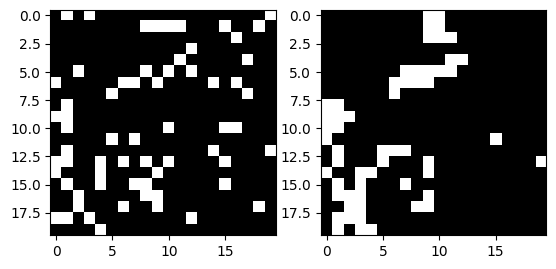

In [13]:
X, y = generate_dataset(1, board_shape=board_shape, prob_alive=probability_alive)

print("Frame to Predict vs. Correct Output:")
render_frames(X[0].flatten().reshape(board_shape), y)

In [14]:
pred = (model.predict(reshape_input(X)) > 0.5).astype(int)
print(np.count_nonzero(pred.flatten() - y.flatten()), "incorrect cells.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7 incorrect cells.


Correct Output vs. Predicted:


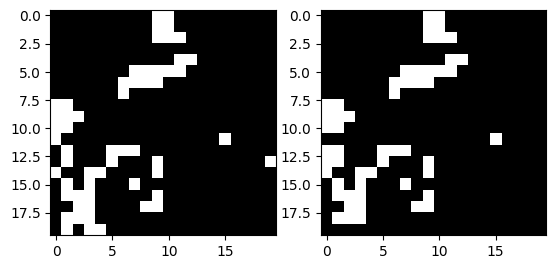

In [15]:
print("Correct Output vs. Predicted:")
render_frames(y, pred.flatten().reshape(board_shape))

It's not terrible, but it's pretty clearly failing to predict the edges. Take a look at the following where non-zero values indicate incorrect predictions:

In [16]:
print(pred.flatten().reshape(board_shape) - y.flatten().reshape(board_shape))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

All the non-zero values are located in the edges of the game board. Let's take a look at the full testing set:

## View Frequent Errors using Test Set

In [17]:
def view_test_errors(model, X_test, y_test):
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)
    sum_y_test_pred = np.sum(y_test_pred, axis=0).flatten().reshape(board_shape)
    sum_y_test = np.sum(y_test, axis=0).flatten().reshape(board_shape)

    plt.imshow(sum_y_test_pred - sum_y_test, cmap='hot', interpolation='nearest')
    plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


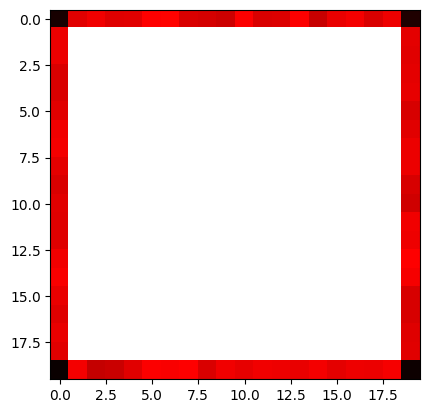

In [18]:
view_test_errors(model, X_test, y_test)

All errors are around the edges, and are worst in the corners. This makes sense since the CNN cannot look around the edges, but the *Game of Life* logic in `life_step` does. 

For example, consider the following. Currently, when looking at the edge cell `x` below, the CNN only sees the `x` and the `!` cells:

```
0 0 0 0 0
! ! 0 0 0 
x ! 0 0 0
! ! 0 0 0 
0 0 0 0 0
```

But what we really want, and what `life_step` is doing, is to look at the cells on the opposite side as well:

```
0 0 0 0 0
! ! 0 0 ! 
x ! 0 0 !
! ! 0 0 ! 
0 0 0 0 0
```

The same logic applies to corner cells, like so:

```
x ! 0 0 !
! ! 0 0 ! 
0 0 0 0 0
0 0 0 0 0
! 0 0 0 !
```


To fix this, the `padding` function of the `Conv2D` needs to somehow look at the opposite side of the game board. Alternatively, each input board could be pre-processed to pad the edges with the opposite side, and then `Conv2D` can simply drop the first/last column and row. 

## Fixing the Edge Issue

We need to pad each game board with the opposite value to simulate how `life_step` looks across the game board for edge values. We can use `np.pad` with `mode='wrap'` to do this, for example:

In [19]:
x = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
np.pad(x, (1, 1), mode='wrap')

array([[9, 7, 8, 9, 7],
       [3, 1, 2, 3, 1],
       [6, 4, 5, 6, 4],
       [9, 7, 8, 9, 7],
       [3, 1, 2, 3, 1]])

Notice now how the first column/row and the last column/row are mirrors of the opposite side. For example, cell `[1][1]` is replicated on the far side in cell `[4][1]`, and likewise `[0][1]` contains `[3][1]`. In every direction, and in the corners, the array has been wrapped to contain its opposite side, just like we want.

Now we can write a function to pad all our input matrices:

In [20]:
def pad_input(X):
    return reshape_input(np.array([
        np.pad(x.reshape(board_shape), (1,1), mode='wrap')
        for x in X
    ]))

X_train_padded = pad_input(X_train)
X_val_padded = pad_input(X_val)
X_test_padded = pad_input(X_test)

print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

(70000, 22, 22, 1)
(10000, 22, 22, 1)
(20000, 22, 22, 1)


All the datasets are now padded with their wrapped columns/rows, allowing the CNN to look around the opposite side of the game board just like `life_step` does.

Next, the CNN must be reconstructed to drop the padding values using `padding='valid'`, and updated to represent the new `input_shape`. This way when we pass in the padded *22x22* game boards we still get predicted 20x20 game boards as output. The rest remains identical:

In [21]:
model_padded = Sequential()
model_padded.add(Conv2D(
    filters, 
    kernel_size,
    padding='valid',
    activation='relu',
    strides=strides,
    input_shape=(board_shape[0] + 2, board_shape[1] + 2, 1)
))
model_padded.add(Dense(hidden_dims_l1))
model_padded.add(Dense(1))
model_padded.add(Activation('sigmoid'))

model_padded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_padded.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 50)     │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20, 20, 100)    │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 20, 1)      │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 20, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,701 (22.27 KB)

 Trainable params: 5,701 (22.27 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
train(model_padded, X_train_padded, y_train, X_val_padded, y_val, filename_suffix='_padded')

Epoch 1/2
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.9512 - loss: 0.1568 - val_accuracy: 1.0000 - val_loss: 4.6128e-04
Epoch 2/2
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 1.0000 - loss: 2.8110e-04 - val_accuracy: 1.0000 - val_loss: 6.7190e-05


Validation and training acuracy are up to 100% from ~98% before adding the padding. Let's see the test error:

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


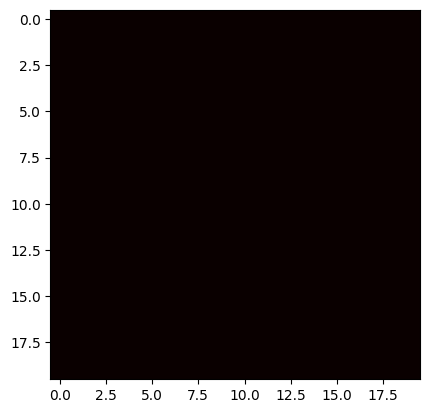

In [23]:
view_test_errors(model_padded, X_test_padded, y_test)

Perfect!